# HSLU-PRA Week 2

Date: 24.04.2020

Author: Niclas Simmler

## Task
* Make yourself familiar with the code to compute the spectrogram.
* Explore the audio file sent to you in the time and frequency domain. Look out for characteristic features that could be specific for the recording.
* Create a picture (A4) of the features, which you assume to be characteristic for your recording.
* Describe the relevant features in 5-10 concise sentences.
* Think of an algorithm to identify the recording out of any other. Write down a rough sketch in form of pseudo-code.

## Setup


In [1]:
%matplotlib inline
import os              
import numpy as np
from scipy import signal
import simpleaudio as sa
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi'] = 200
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Helper

Helper functions to handle the sound playing and plotting.

In [2]:
class Spec(object):
    def __init__(self):
        self.sound = None
        self.fs = None
    
    def __repr__(self):
        return self.__str__()
    
class Sound_Spec(Spec):
    def __init__(self, freq, fun, fs, sound = None, superpositioned = False):
        self.freq = freq
        self.fun = fun
        self.fs = fs
        self.sound = sound
        self.superpositioned = superpositioned
        
    def __str__(self):
        suffix = 'Superpositioned' if self.superpositioned else ''
        return f'Sound Spec: {self.freq} Hz {suffix}'
    
class Sound_File_Spec(Spec):
    def __init__(self, path):
        self.path = path
        self.fs, self.sound = wavfile.read(self.path)
        
    def __str__(self):
        filename = os.path.basename(self.path)
        return f'Sound File Spec: {filename}'

In [3]:
def play(spec):
    play_obj = sa.play_buffer(spec.sound, 1, 2, spec.fs)
    play_obj.wait_done()

def waveform(spec, start=0, end = 1000000):
    plt.plot(spec.sound[int(spec.fs*start):int(spec.fs*end)])
    tkr_major = ticker.FuncFormatter(lambda x, pos: '{0:.2f}'.format((x/spec.fs)+start))
    ax = plt.gca()
    ax.xaxis.set_major_formatter(tkr_major)
    plt.xlabel('Time [sec]')
    plt.show()


In [4]:
def generate_sounds(specs=[], 
                   duration=1, 
                   sample_rate=44100, 
                   superposition=False, 
                   plot=True, 
                   play=True, 
                   output=False, 
                   plot_window_size_nth=400):
    """
    Generates sound

    Generates sound according to provided specifications

    Parameters
    ----------
    specs : list
        List of sound specifications
    duration : int
        Length of sound to generate
    sample_rate : int
        Sample rate used for sound generation (information per second)
    superposition : boolean
        Superposition all specs and thus generate an additional sound (if only one spec is provided this will forced to False)
    plot : boolean
        Plot the sounds as waves
    play : boolean
        Play the generated sound
    output : boolean
        Prints progress information
    plot_window_size_nth : int
        Defines the scaling of the x-axis -> x-axis will be limited to the n-th part of the duration

    Returns
    -------
    list
        Updated spec information which now also contains the generated sound. List will have n+1 elements if superposition was set to True.

    """
    legend_data = []
    t = np.linspace(0, duration, duration * sample_rate, False)
    if len(specs) == 0:
        return
    if len(specs) == 1:
        superposition = False
    sound = np.sin(0 * t * 2 * np.pi) # empty sound
    for spec in specs:
        if output:
            print(spec)
        legend_data.append(str(spec))
        if superposition:
            addition = (1/len(specs)) * spec.fun(spec.freq * t * 2 * np.pi) 
            addition = addition * (2**15 - 1) / np.max(np.abs(addition))
            addition = addition.astype(np.int16)
            sound = sound + addition
            spec.sound = addition
        else:
            sound = spec.fun(spec.freq * t * 2 * np.pi)
            sound = sound * (2**15 - 1) / np.max(np.abs(sound))
            sound = sound.astype(np.int16)
            spec.sound = sound
        if play:
            play_obj = sa.play_buffer(spec.sound, 1, 2, sample_rate)
            play_obj.wait_done()
    if superposition:
        legend_data.append(f'Superpositioned')
        if output:
            print('Superpositioned')
        sound = sound * (2**15 - 1) / np.max(np.abs(sound))
        sound = sound.astype(np.int16)
        superpositioned_spec = Sound_Spec(freq=-1, fun=None, sound = sound, fs = sample_rate, superpositioned=True)
        specs.append(superpositioned_spec)
        if play:
            play_obj = sa.play_buffer(superpositioned_spec.sound, 1, 2, sample_rate)
            play_obj.wait_done()
    if plot:
        for spec in specs:
            plt.plot(t[:int(len(t)/plot_window_size_nth)], spec.sound[:int(len(t)/plot_window_size_nth)], linestyle='dotted' if spec.superpositioned else 'solid')
        plt.legend(legend_data, bbox_to_anchor=(1.04,1), loc="upper left")
        plt.show()
    return specs

In [5]:
def visualize(specs, 
              start = 0, 
              end = 1000000, 
              f_trans = 'default', 
              sxx_trans = 'default', 
              title = None, 
              columns = 2, 
              **spectrogram_args):
    """
    Generates and visualizes the spectrogram

    Generates a spectrogram from a Spec object and visualizes it

    Parameters
    ----------
    specs : list
        List of sound specifications
    start : int
        Start element where to start
    end : int
        End element where to start
    f_trans : str or lambda
        Transformation function to be used for frequency transformation. Possible options are: 'default','mel' or a custom lambda function.
    sxx_trans : str or lambda
        Transformation function to be used for spectrogram transformation. Possible options are: 'default', 'log', mel' or a custom lambda function.
    title: str
        A custom title for the plot
    columns: int
        If multiple specs are passed, this parameter will define how many columns are used to plot them.
    **spectrogram_args: dict
        Any additional argument will be passed to scipy.signal.spectrogram.
    
    Returns
    -------
    None
    
    """
    size = 8
    if type(specs) != type(list()):
        specs = [specs]
    count_plots = len(specs)
    count_cols = columns
    if len(specs) < count_cols:
        count_cols = len(specs)
    count_rows = (count_plots // count_cols) + (count_plots % count_cols)
    position = range(1,count_plots+1)
    
    fig = plt.figure(1)
    plt.rcParams["axes.labelsize"] = 'xx-small'
    
    transformations = {
        'default': lambda x: x,
        'log': lambda x: np.log(x),
        'mel': lambda x: 2595*np.log(1+(x/700))
    }
    if not callable(f_trans):
        if f_trans not in transformations.keys():
            raise Exception('Frequency Transformation not valid!')
        if f_trans in ('log'):
            f_trans = 'default'
    if not callable(sxx_trans):
        if sxx_trans not in transformations.keys():
            raise Exception('Spectrogram Transformation not valid!')
    
    for i, spec in enumerate(specs):
        f, t, Sxx = signal.spectrogram(spec.sound[int(spec.fs*start):int(spec.fs*end)], fs=spec.fs, **spectrogram_args)
        f = list(map(f_trans if callable(f_trans) else transformations[f_trans], f))
        Sxx = list(map(sxx_trans if callable(sxx_trans) else transformations[sxx_trans], Sxx))
        
        ax = fig.add_subplot(count_rows, count_cols, position[i])
        m = ax.pcolormesh(t+start, f, Sxx)
        ax.set_title(str(spec), fontsize=size//2)
        
        cbar = fig.colorbar(m)
        cbar.ax.tick_params(labelsize=size//2)
        ax.set_ylabel('Frequency [Hz]')
        if count_cols > 1:
            ax.set_xlabel('Time [sec]')
        ax.tick_params(labelsize=size//2)
    if count_cols == 1:
        plt.xlabel('Time [sec]')
    if title is not None:
        plt.suptitle(title, fontsize=size)
    plt.subplots_adjust(hspace=0.3, wspace=0.4)
    plt.show()

## Submission

### Make yourself familiar with the code to compute the spectrogram.

We will first setup some data.

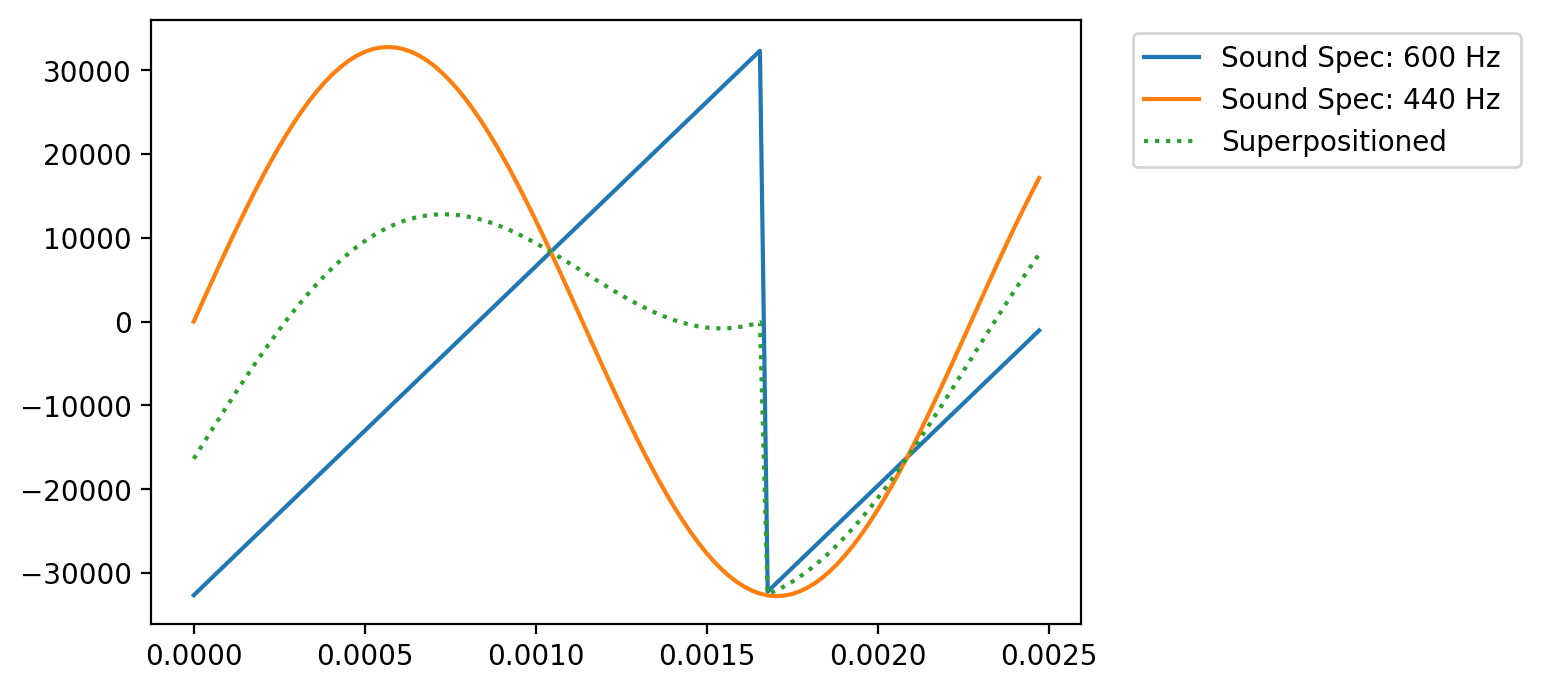

In [6]:
# Setup
duration, sample_rate = 1, 44100
# Generate Sounds
specs = generate_sounds(
    specs = [Sound_Spec(freq=600,fun=lambda x: (x % (np.pi * 2)) - np.mean(x % (np.pi * 2)),fs=sample_rate), 
             Sound_Spec(freq=440,fun=np.sin,fs=sample_rate)], 
    duration = duration,
    sample_rate = sample_rate,
    play=False, 
    plot=True,
    output=False,
    superposition=True
)
# Load some sounds
wav_specs = []
horn_spec = Sound_File_Spec('./data/horn.wav')
mundart_spec = Sound_File_Spec('./data/mundart.wav')
wav_specs.append(horn_spec)
wav_specs.append(mundart_spec)

Experiment with parameters on the wav files.
First we will have a look at the *nperseg* and *nfft* parameter.




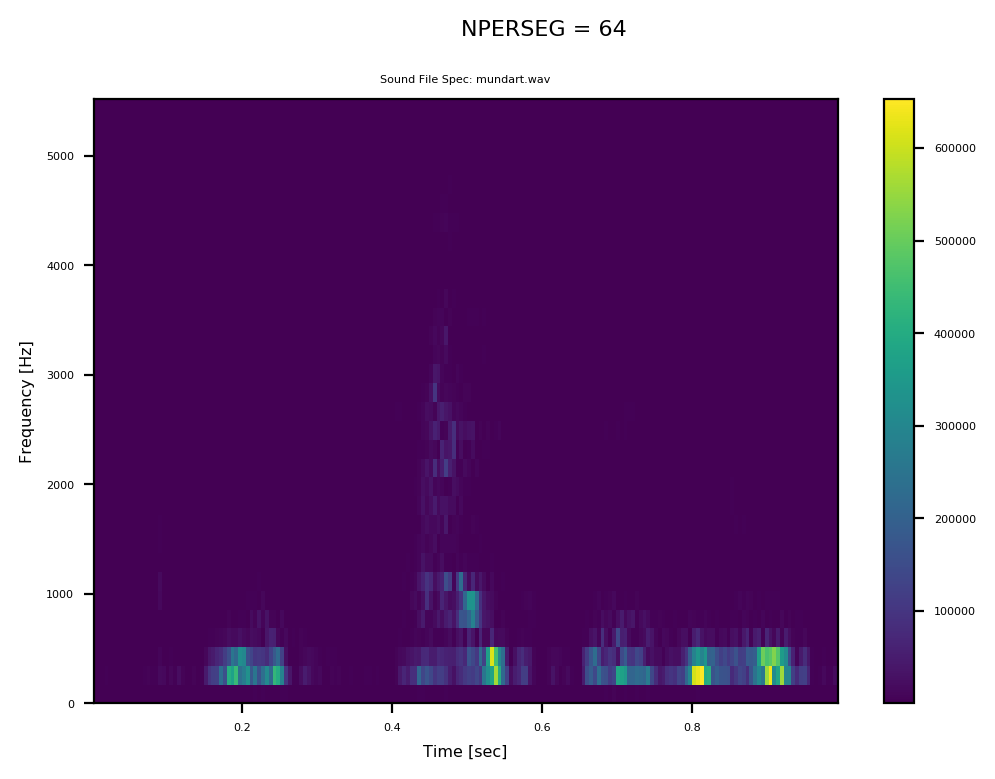

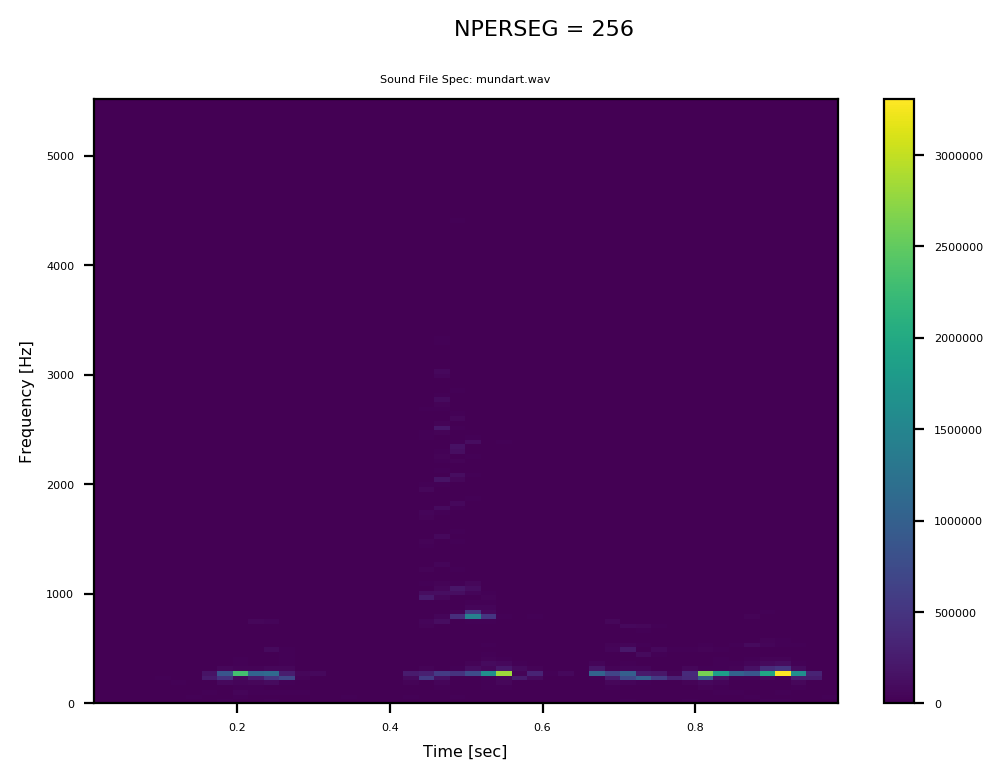

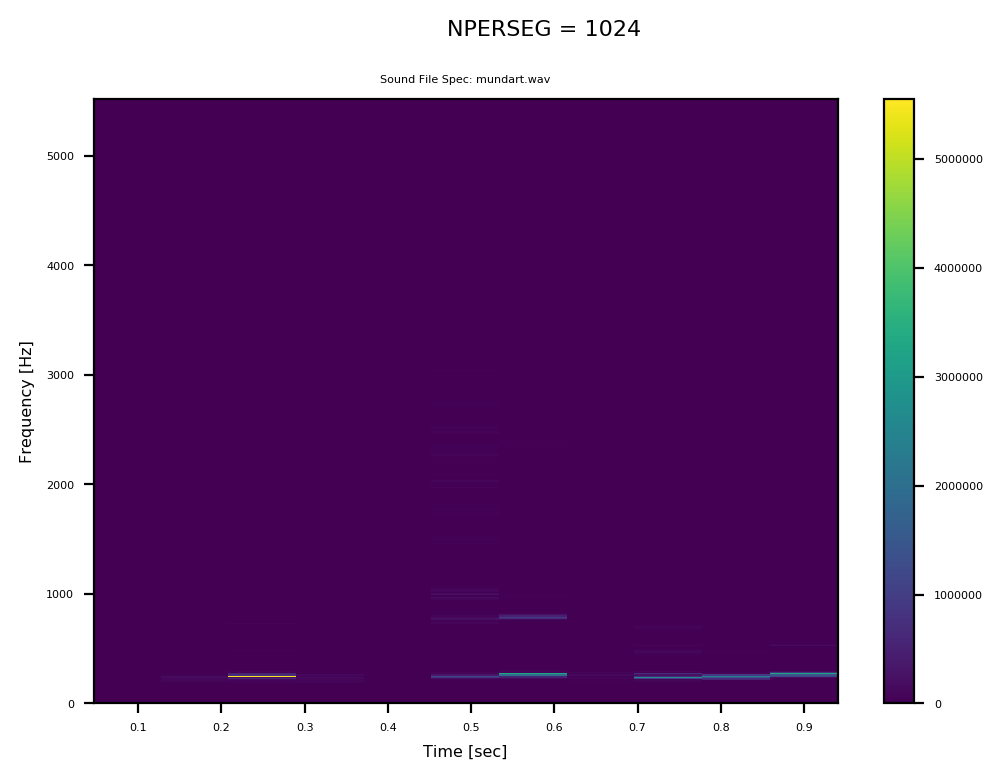

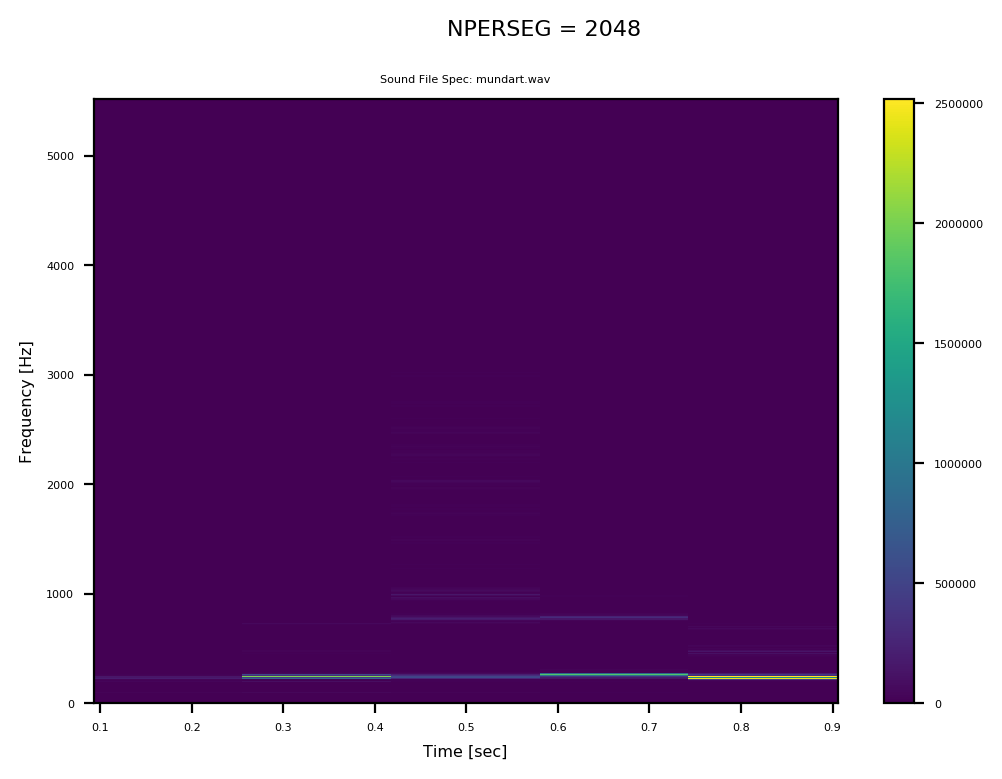

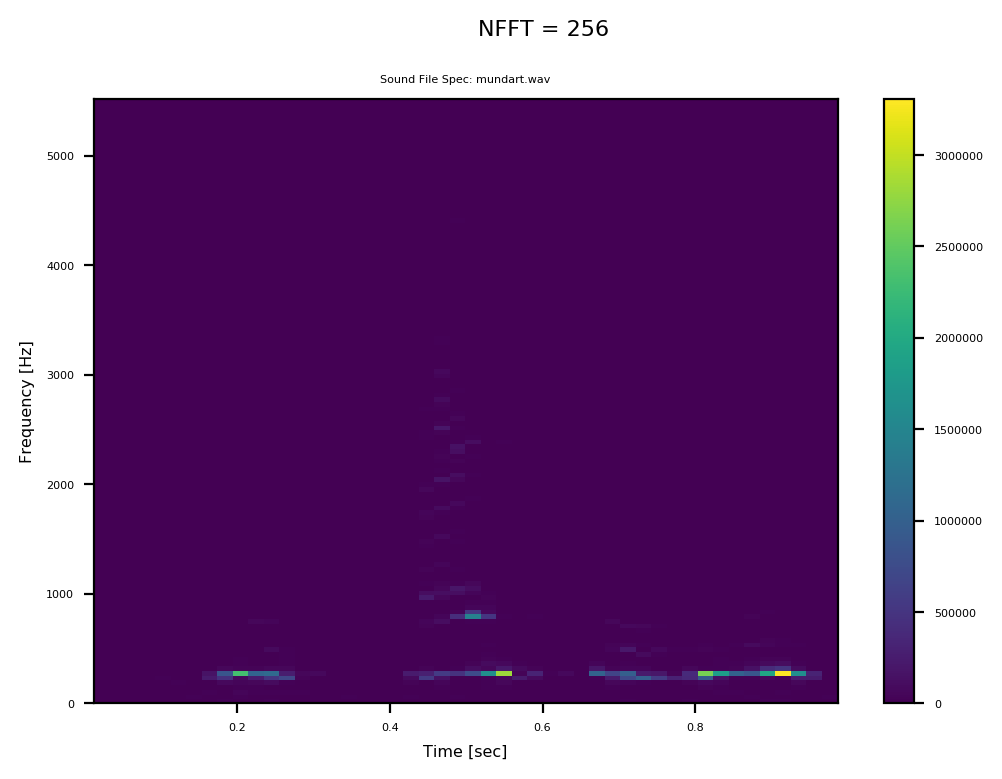

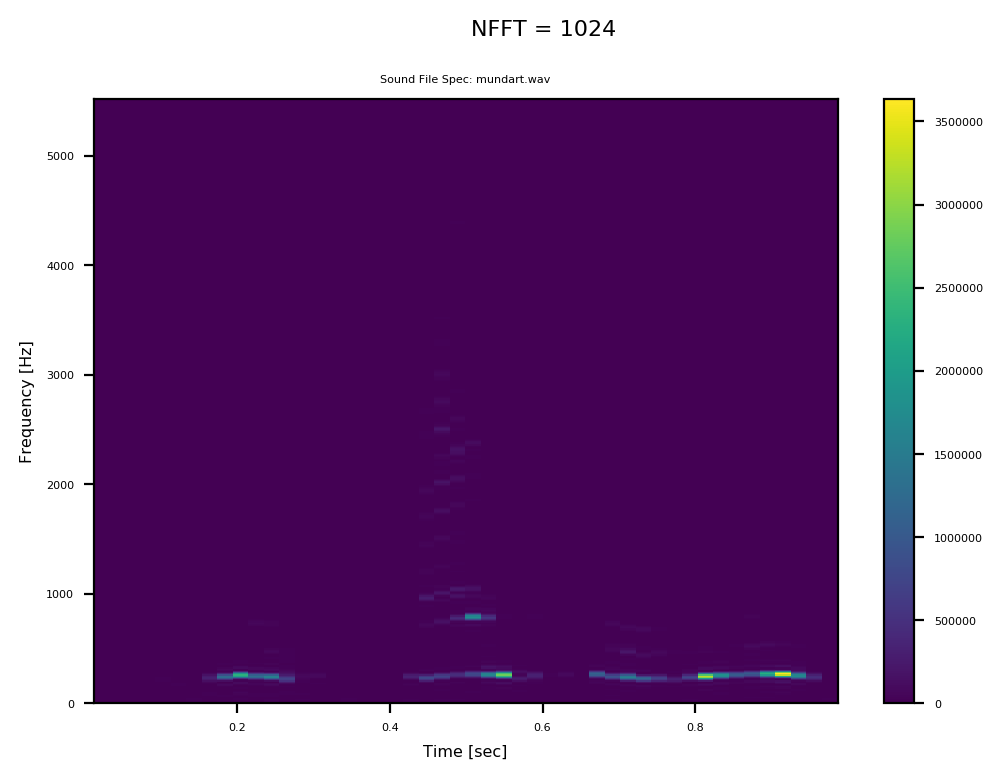

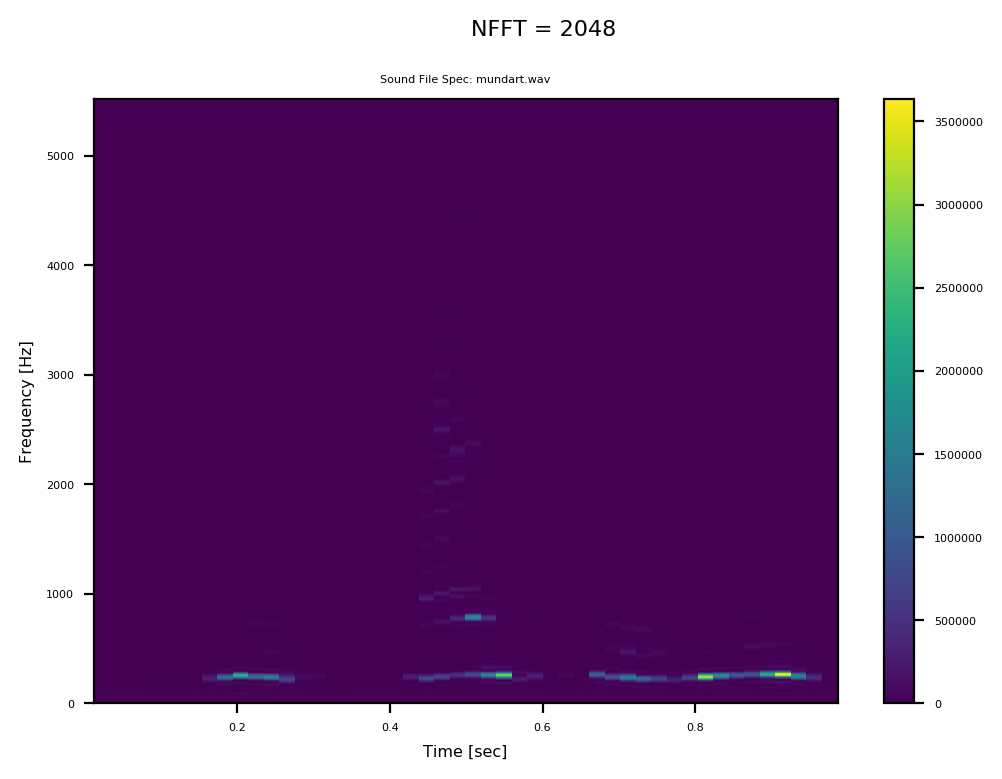

In [7]:
param = [64, 256, 1024, 2048]
for n in param:
    visualize(wav_specs[-1:], start=0, end=1, title = 'NPERSEG = {}'.format(n), columns=1, nperseg=n)
    
for n in param:
    if n == 64: continue
    visualize(wav_specs[-1:], start=0, end=1, title = 'NFFT = {}'.format(n), columns=1, nfft=n)

By varying the *nperseg* parameter, we can control the resolution of the x-axis. The higher we go, the wider the windows will get. By varying the *nfft* parameter, we can control the resolution of the y-axis, the higher we go, the more finegrained we will resolve the frequencies.

Next we will experiment with the windows.


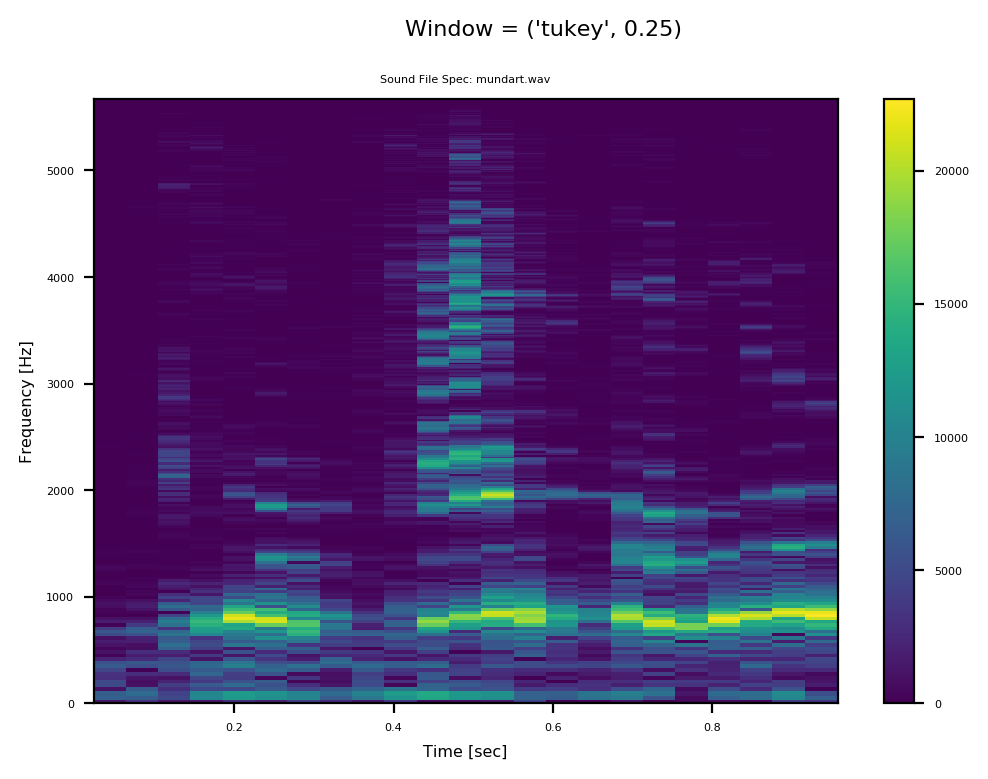

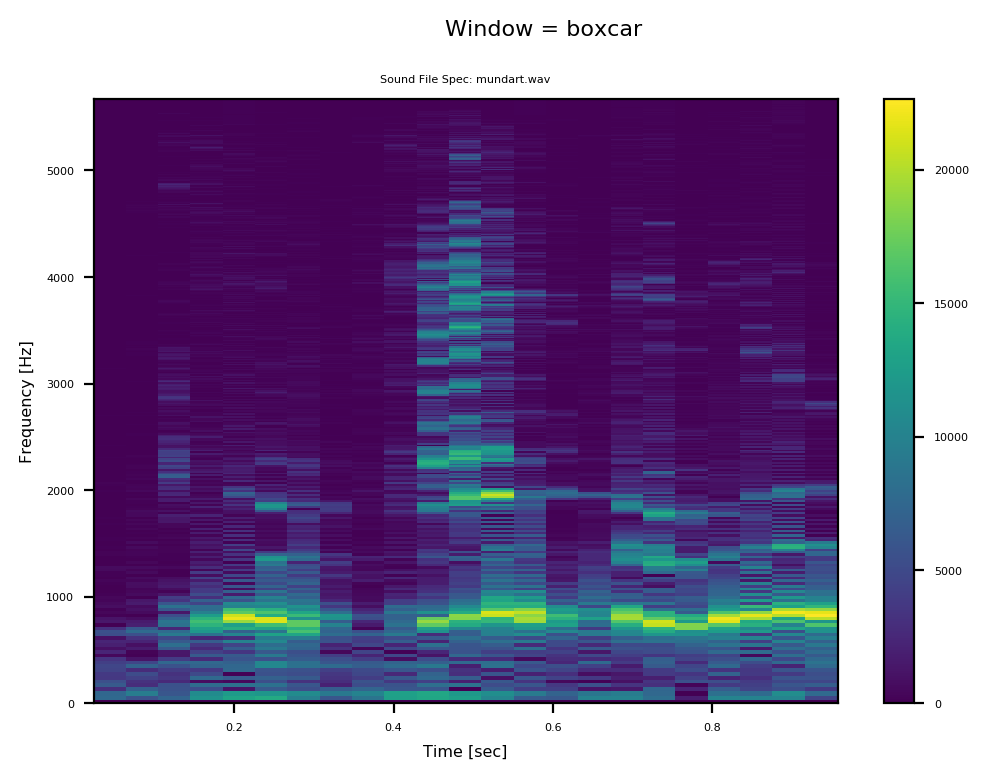

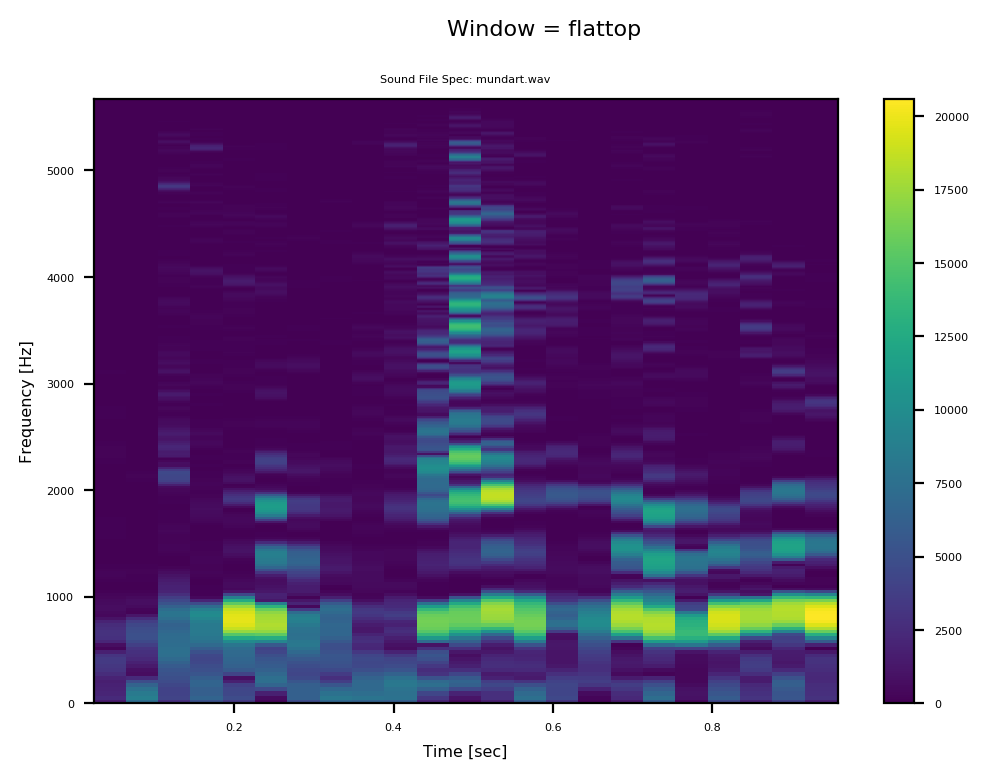

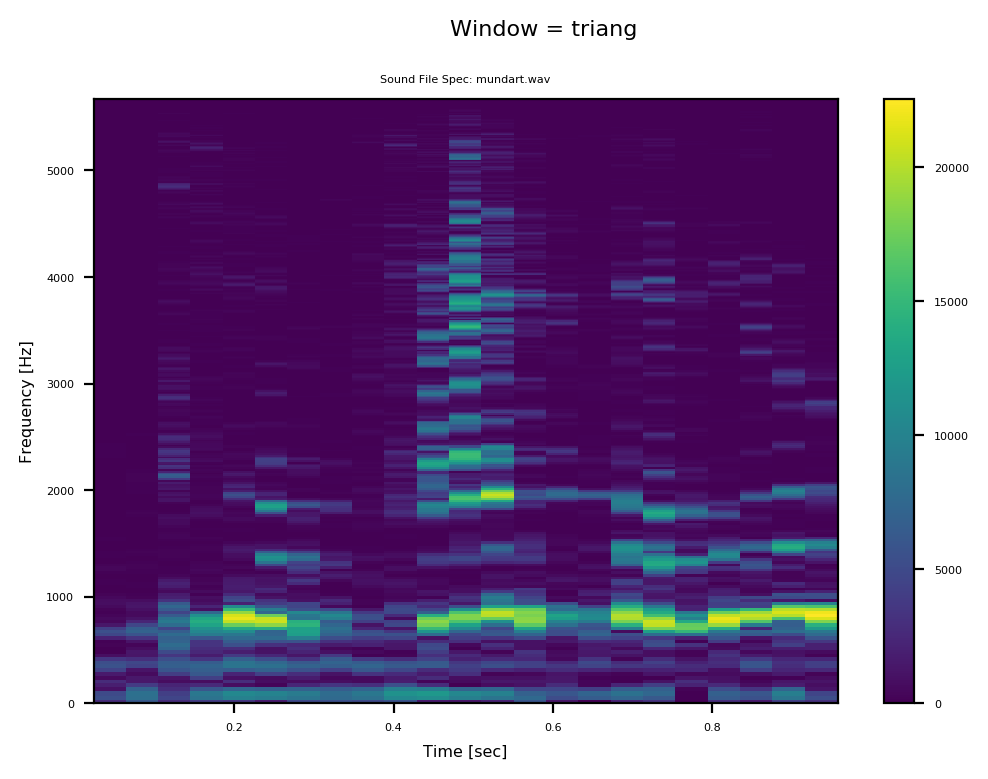

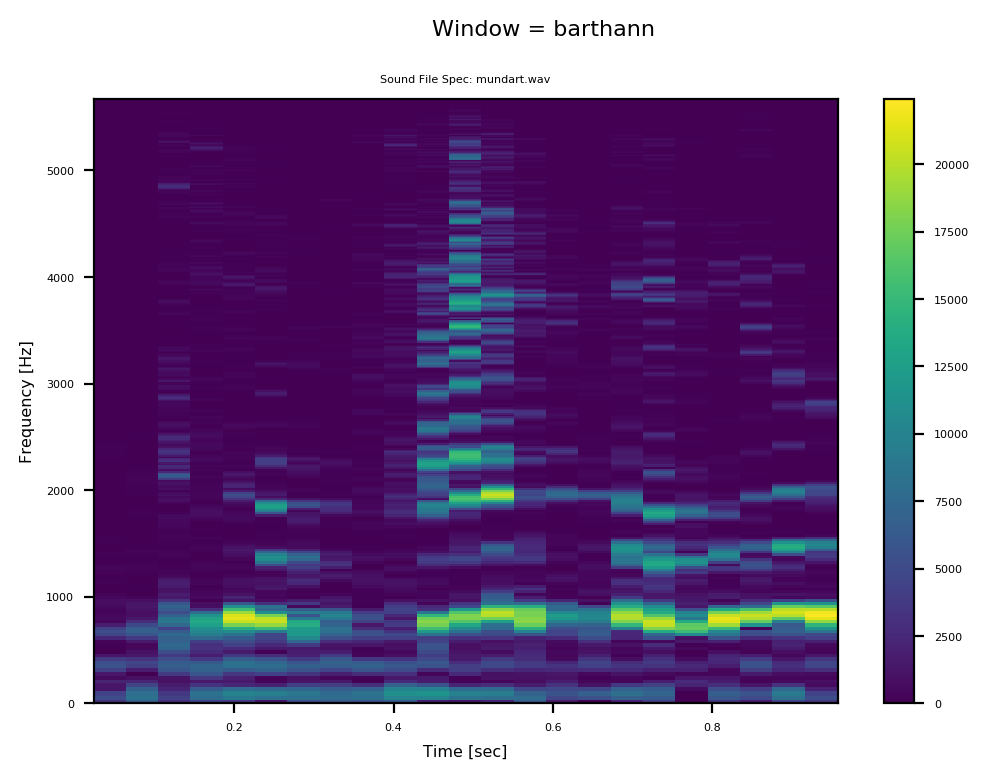

In [8]:
windows = [('tukey', 0.25),('boxcar'),('flattop'),('triang'),('barthann')]
for window in windows:
    visualize(wav_specs[-1:], start=0, end=1, f_trans='mel', sxx_trans='mel', title = 'Window = {}'.format(window), columns=1, 
              window=window, nperseg=512, nfft=1024)

As we can see, the window can give us a lot of control over how smooth the plot looks like. The level of detail is defined by the form of the window (curve) as defined here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html


We will now experiment with various transformations. As we can see from the plots above, we can see a lot of information in the lower frequency (< 1000 Hz) ranges but we cannot see much in the upper ranges (2 kHz - 5 kHz). Also the resolution of the color levels are not so fine grained. We can adjust this by transformations. Specifically, there is a logarithmic transformation and we have the mel transformation, which is an improvement on the plain logarithmic scale.


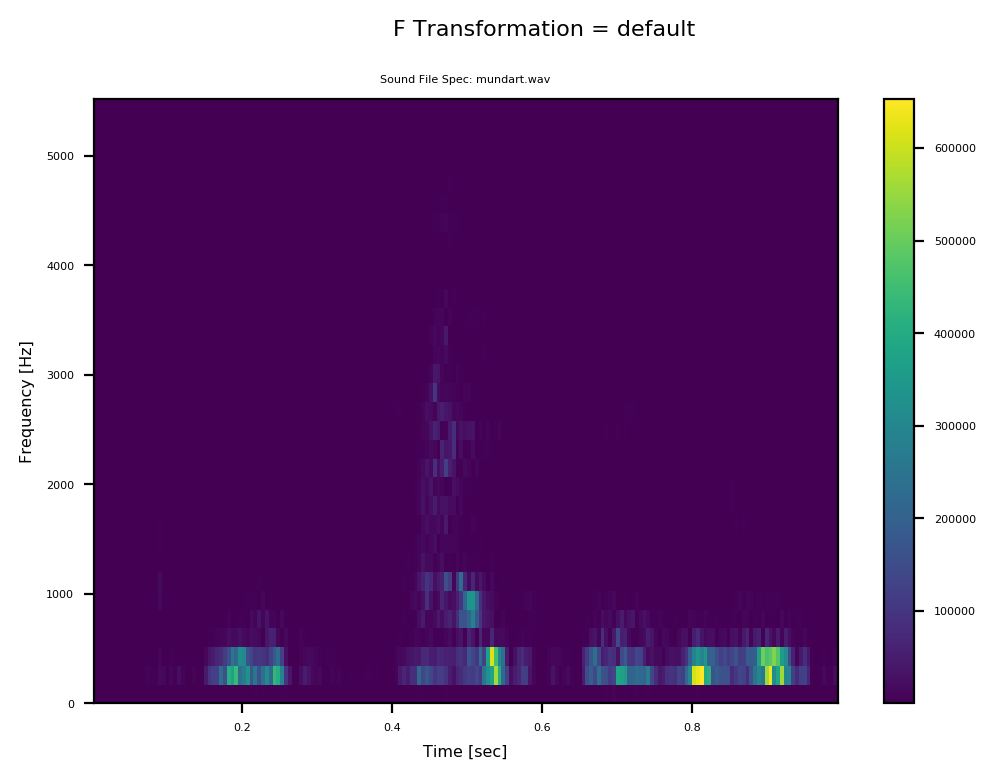

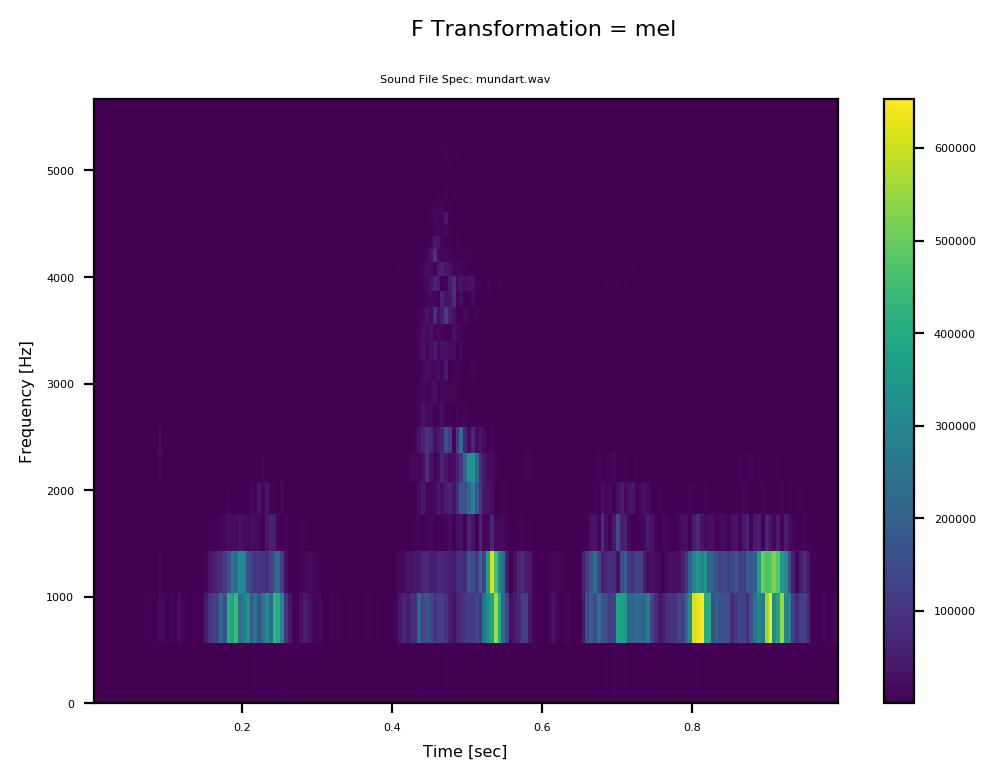

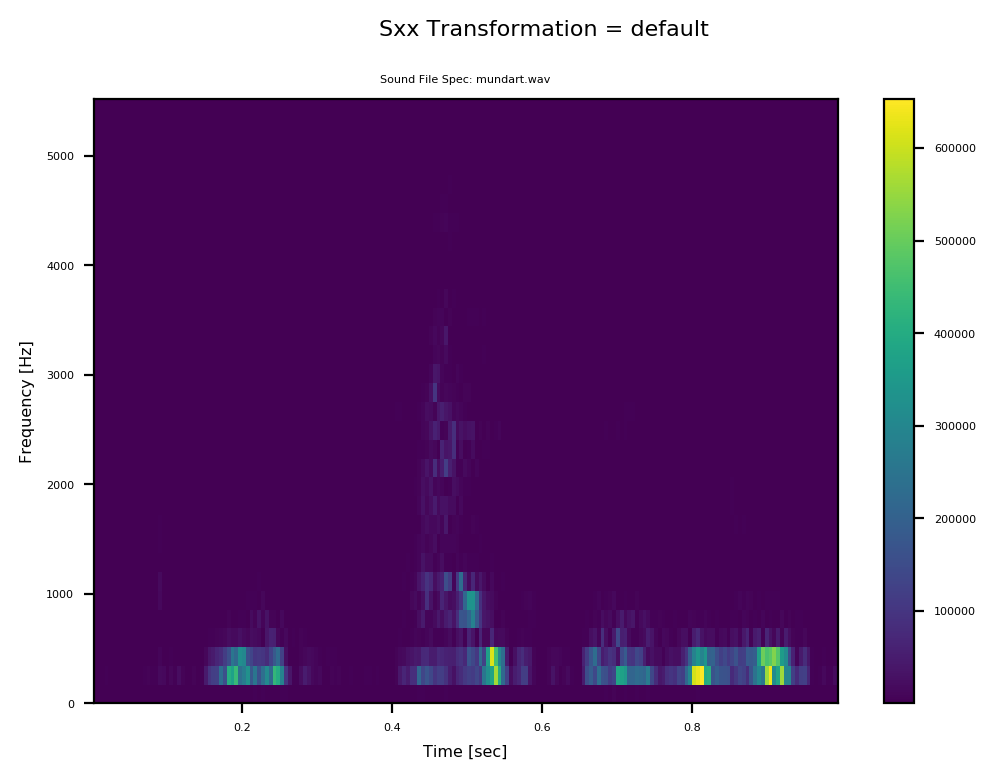

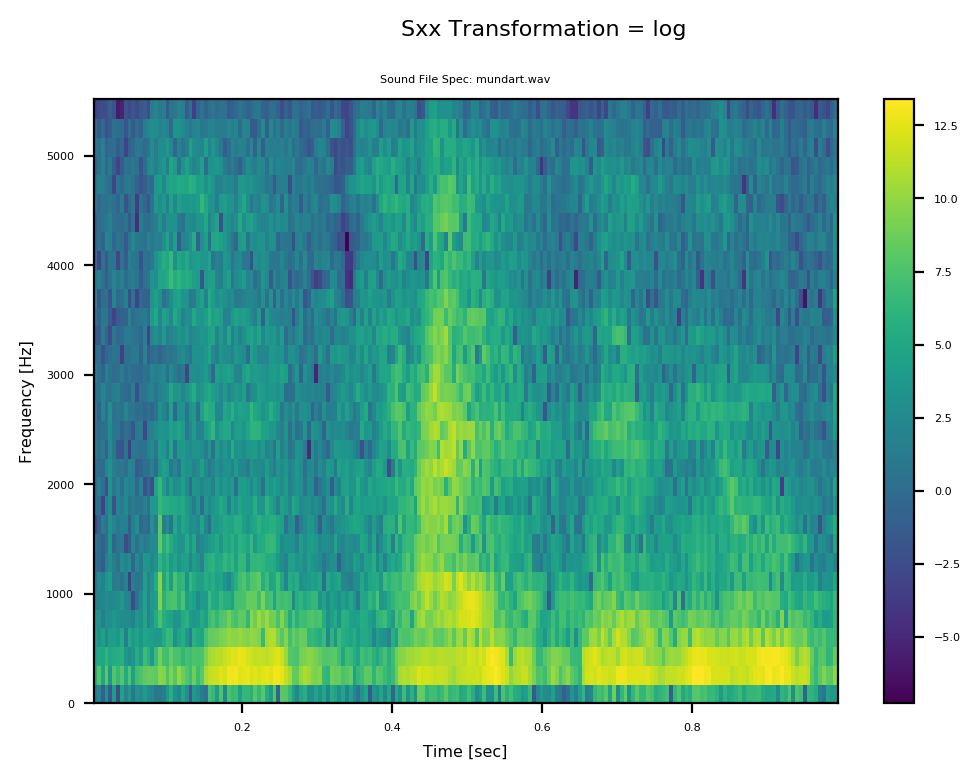

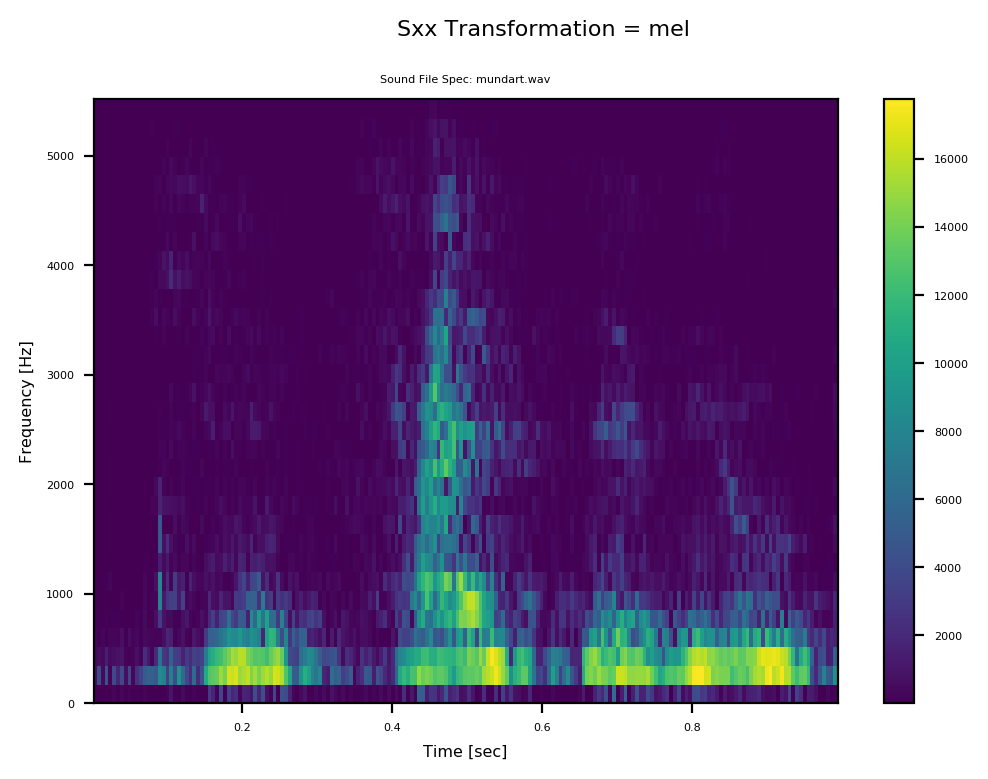

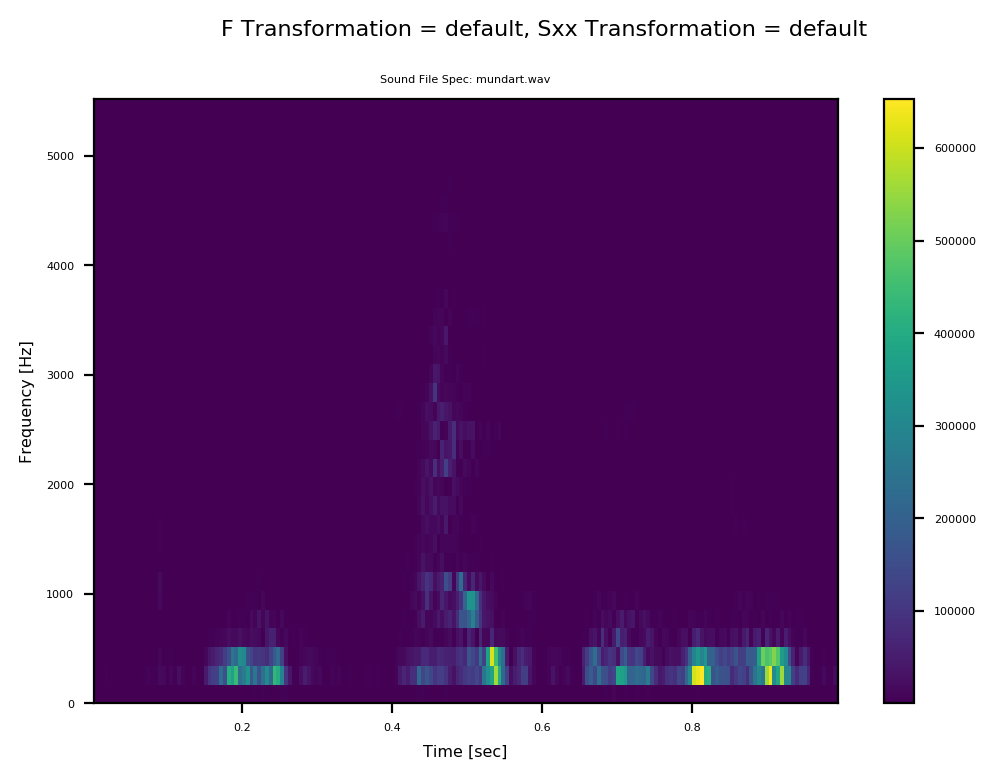

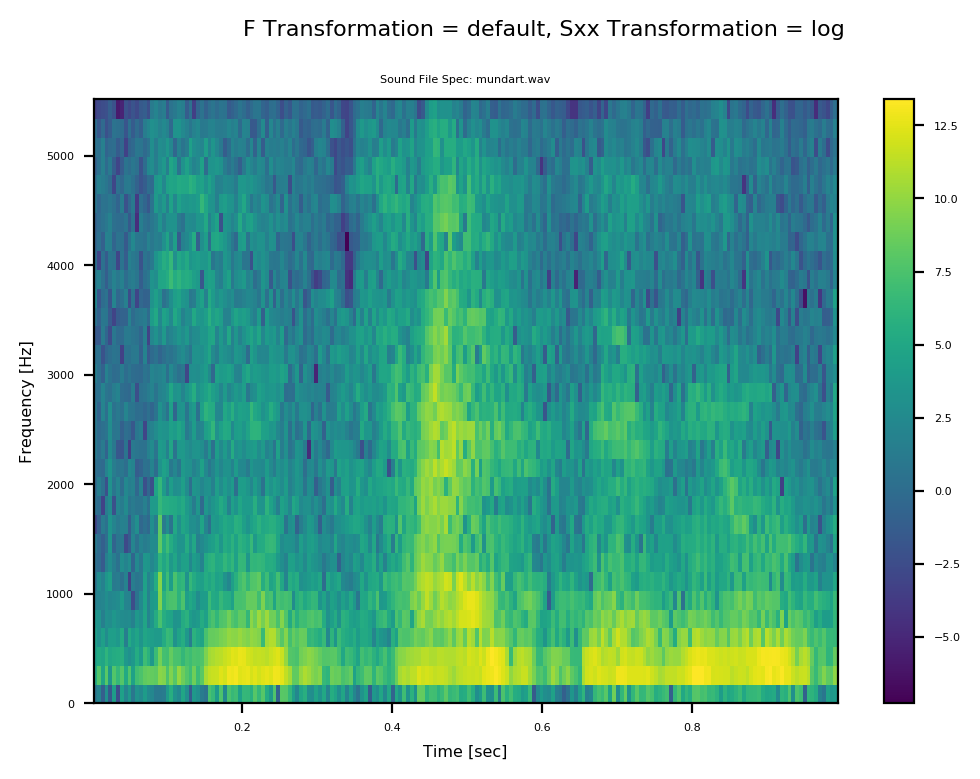

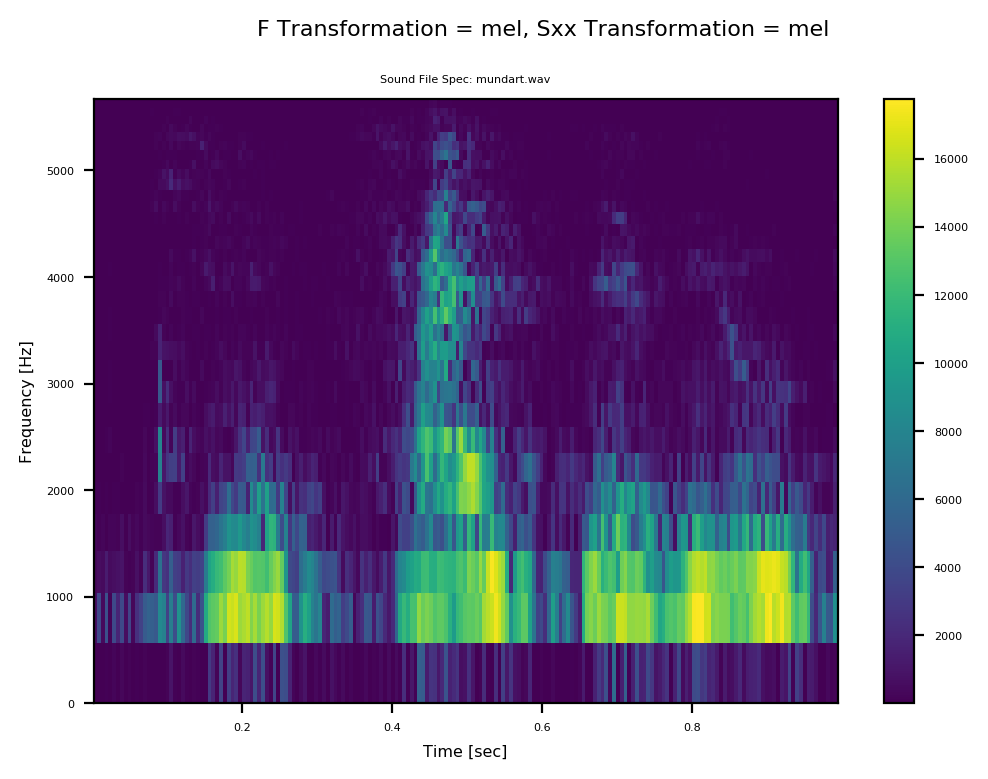

In [9]:
transformations = ['default', 'log', 'mel']
for t in transformations:
    if t == 'log': 
        continue
    visualize(wav_specs[-1:], start=0, end=1, f_trans = t, title = 'F Transformation = {}'.format(t), columns=1, nperseg=64)
for t in transformations:
    visualize(wav_specs[-1:], start=0, end=1, sxx_trans = t, title = 'Sxx Transformation = {}'.format(t), columns=1, nperseg=64)
for t in transformations:
    visualize(wav_specs[-1:], start=0, end=1, f_trans = t, sxx_trans = t, title = 'F Transformation = {}, Sxx Transformation = {}'.format('default' if t == 'log' else t,t), columns=1, nperseg=64)

We tuned two individual transformations. There is the *f_trans* parameter which transforms the frequency and the *sxx_trans* parameter which transforms the spectrogram (i.e. the color nuances). By applying a logarithmic scale, in particular 'mel', we can clearly see bigger chunks of representation in the lower frequency regions and fine grained and detailed chunks in the higher frequency regions - which is where the actual spoken word lies.

For now we have looked at real life recordings, since there is more frequencies to be seen. But it is also interesting to look at synthetic sounds.

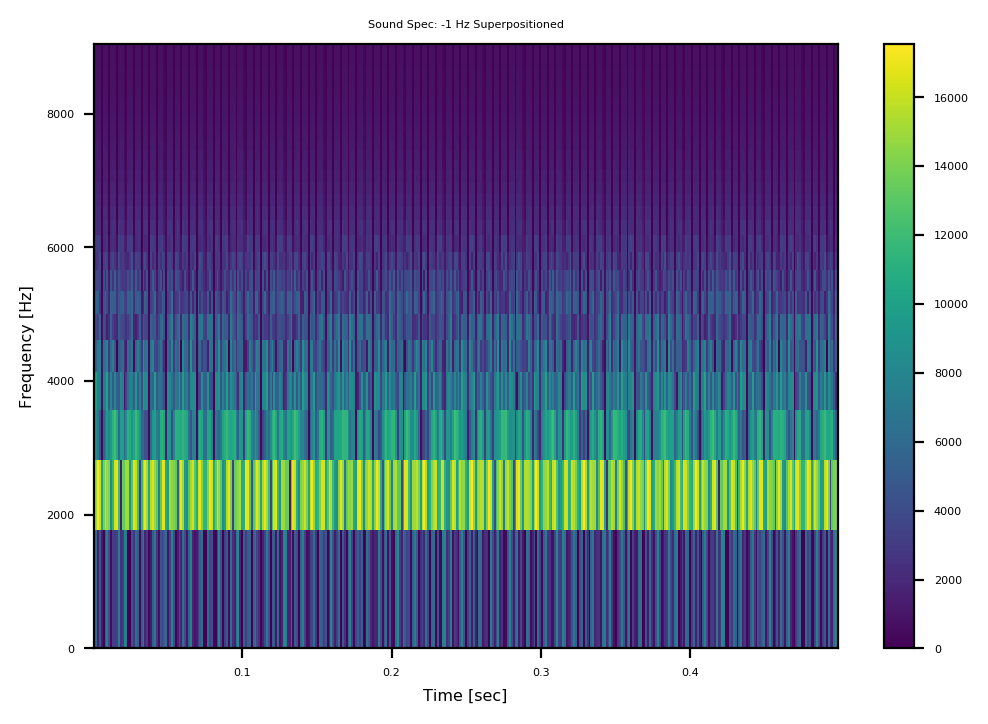

In [10]:
visualize(specs[-1:], start=0, end=0.5, f_trans = 'mel', sxx_trans = 'mel', columns=1, nperseg=64)

For the synthetic sound, we can see a lot of activity in the 2kHz-3kHz region. But there are also many other frequencies involved in this sound. This is probably also due to the fact, that we superpositioned a sine wave with a sawtooth wave. This means, that there are a lot of smaller frequencies involved to generate the shape.

### Explore the audio file sent to you in the time and frequency domain. Look out for characteristic features that could be specific for the recording.

Here we are already looking at a random 5s snippet of the audio file, since the audio file is 5minutes long. In this exercise we are considering the artefact we have received in SW1.

In [11]:
snippet = Sound_File_Spec('./data/190815_001_snippet.wav')

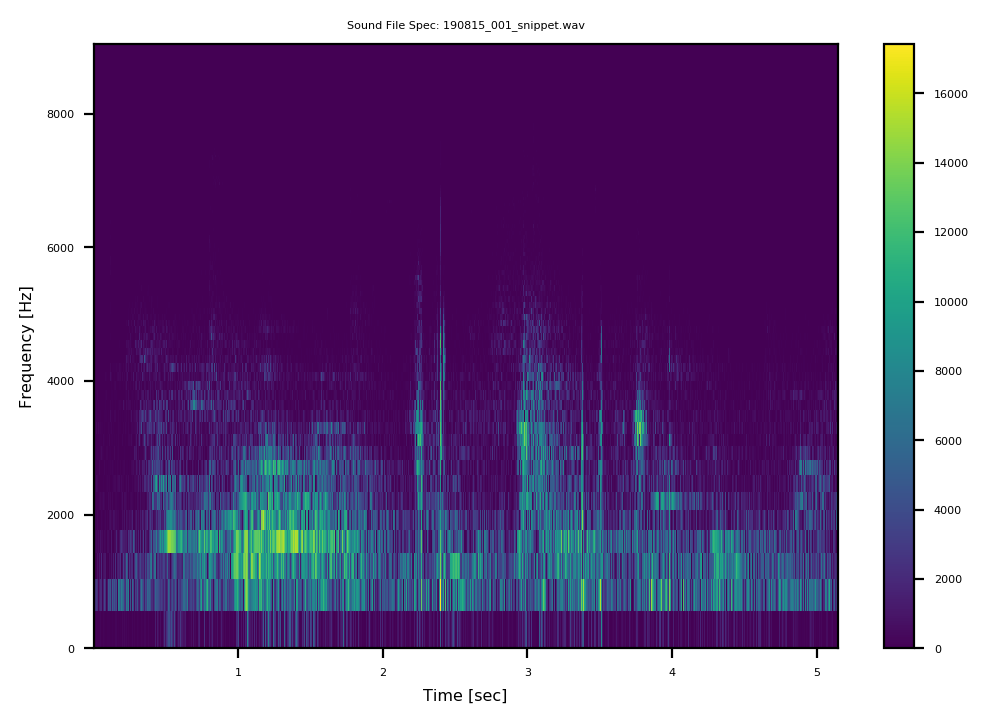

In [12]:
visualize(snippet, f_trans='mel', sxx_trans='mel')

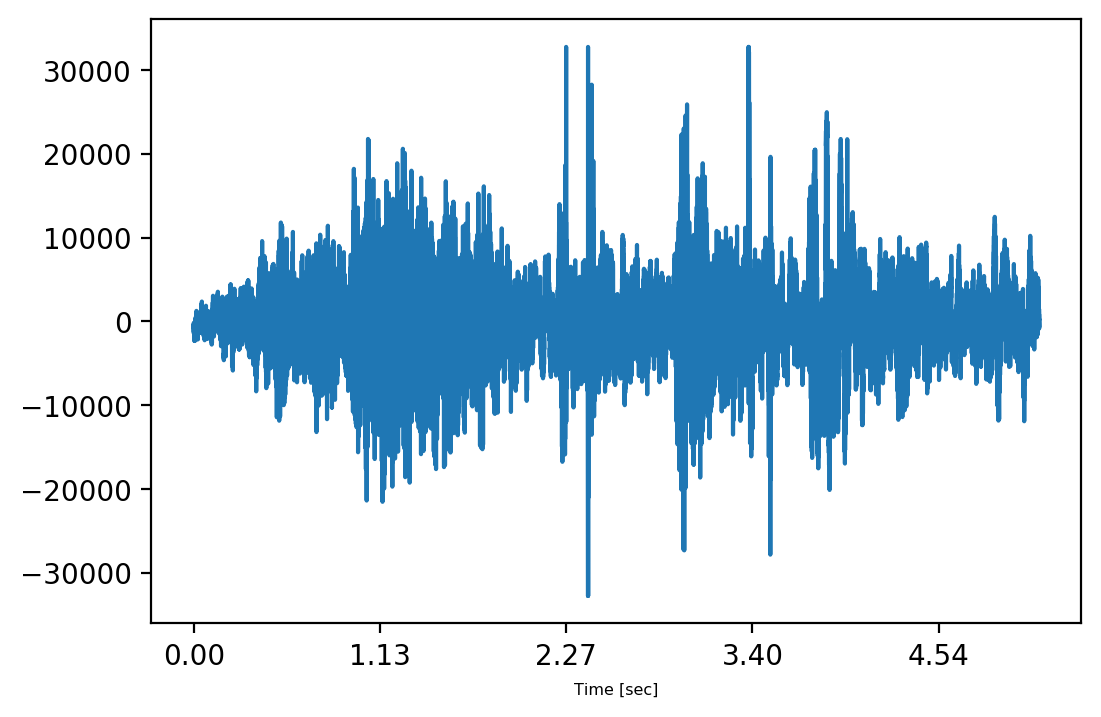

In [13]:
waveform(snippet)

According to the spectrogram there is a lot of activity in the lower frequency bands (up to 4 kHz). Sometimes there are some spikes which go above the 4 kHz frequency.
We can also see the spikes in the time domain, where the spikes in the amplitude are present going over 20000.

### Create a picture (A4) of the features, which you assume to be characteristic for your recording.


In the recording there are various artefacts that originate from somebody touching the microphone (described as spikes in the previous chapter). The are visible in the spectrogram as well as in the waveform (high amplitudes).

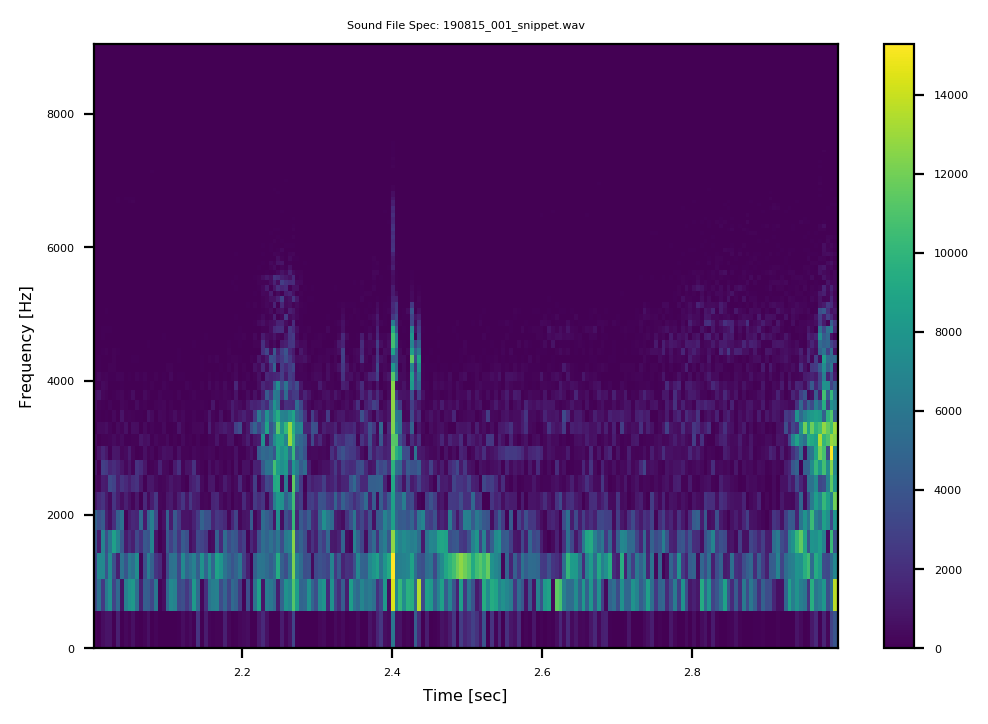

In [14]:
visualize(snippet, f_trans='mel', sxx_trans='mel', start=2, end=3)

In the spectrogram we can see these artefacts for instance at 2.4s, where we have activity across all frequency bands.

### Describe the relevant features in 5-10 concise sentences.


* The artefact is visible within a lot more frequencies compared to the rest of the recording.
* Given the proximity to the microphone, we can see a lot more intensity in the spectrogram for said segment.
* When looking at the intensity, there is a sudden increase of intensity for each frequency and a sudden drop afterwards.
* A lot more frequencies are involved compared to other segments (from 0 Hz to 7 kHz).
* Most frequencies are equally involved in the "noise", so it is not only low frequencies.
* Since so many frequencies are involved, the artefact appears to be noise.

### Think of an algorithm to identify the recording out of any other. Write down a rough sketch in form of pseudo-code.

The algorithm should look at all segments and calculate for all of them the ratio of frequencies substantially involved and the frequencies not involved (there will be a threshold value here). The intensity shall be factored in too. The total sum of each segment will be stored.
This calculate data shall then be compared to amongst each datapoint. Outliers will represent the artefact.

```
intensity_threshold = 4000
outlier_deviation = 1.75

for each segment:
    segment_sum = 0
    for each frequency:
        segment_sum += frequency * intensity if frequency >= intensity_threshold else 0
    store segment_sum

calc_stdev = standard_deviation(segment_sums)
calc_mean = mean(segment_sums)

for each segment_sum:
    if segment_sum > outlier_deviation * (calc_mean + calc_stdev):
        "Artefact identified"

```

The algorithm may be improved by considering the previous and the following segment. If they are significantly lower in *segment_sum*, then we are a lot more confident, that we have found the artefact.